# Throughput Analysis 

This notebook analyzes the throughput and model FLOP utilization (MFU) of sweeps across different dimensions such as sequence lengths and attention implementations. 
It visualizes the results in two plots: one for throughput and another for MFU.

A sweep is stored as a nested directory structure following the pattern:
`<timestamp_sweep_hash>/<num_ranks>/<config_hash_timestamp>`

Below is an example of this directory structure. At the top level, the runs are divided by the number of ranks used in the sweep.
Typically each rank folder contains the same experiments, the only difference is the number of ranks used.

We differentiate between successful runs, failed runs and runs that have not been executed yet.

* For a successful run, either the evaluation_result.jsonl file is present with the expected number of measurements (i.e., rows) or the error logs contain only expected errors (e.g., OOM).
* For a failed run, the error logs contain unexpected errors (e.g., IB timeout) or the evaluation_results.jsonl file is missing.
* For runs that have not been executed yet, the directory structure is present but no output files are generated.

Note that, sometimes an unexpected error might not be caught by the environment, in this case such a run is considered as not executed yet.

```txt
|-- 1024
|   |-- 12a3d358_2025-07-28__14-13-18                   # successful run
|   |   |-- evaluation_results.jsonl
|   |   |-- sweep_8B_fsdp2.yaml
|   |   `-- sweep_8B_fsdp2.yaml.resolved                                               
|   |-- 1046550d_2025-07-28__14-13-18                   # not run yet or failed with unexpected / non-caught error (e.g., IB timeout)
|   |   `-- sweep_8B_fsdp2.yaml
|   |-- 93a3f658_2025-07-28__14-13-18                   # failed run
|   |   `-- sweep_8B_fsdp2.yaml
|   |   |-- error_logs_lrdn0722.leonardo.local_0.log
|   |   `-- ...
|   |-- 93a3f658_2025-07-29__20-13-18                   # successful  rerun of failed run 93a3f658_2025-07-28__14-13-18
|   |   |-- evaluation_results.jsonl
|   |   |-- sweep_8B_fsdp2.yaml
|   |   `-- sweep_8B_fsdp2.yaml.resolved   
|   `-- ...
|-- 512                                               
|   |-- 93a3f658_2025-07-28__14-13-18                  
|   |   `-- sweep_8B_fsdp2.yaml
|   `-- ...
`-- ...                                               
```
When evaluating the throughput, we first filter only the most recent runs, i.e., for each config only the one with the most recent timestamp is considered.
In the example above, the run `93a3f658_2025-07-29__20-13-18` is considered for the throughput analysis instead of the run `93a3f658_2025-07-28__14-13-18`.

Each row in the `evaluation_results.jsonl` file contains the results of a single training step, including metrics such as loss, consumed tokens, gradient norms, and throughput metrics.

```json
{
  "dataloader_tag":"train",
  "num_train_steps_done":1,
  "losses":{
    "train loss avg":11.625,
    "train loss last":11.625
  },
  "metrics":{
    "consumed tokens":16384,
    "grad norm avg":42.65726852416992,
    "grad norm last":42.65726852416992
  },
  "throughput_metrics":{
    "train samples/s":2.747027635574341,
    "train mfu (16-bit)":0.1790606826543808,
    "lr mean":6.00299415509653e-07,
    "peak memory rank 0 (MB)":28988.275390625
  }
}
```

## Helper Scripts

In [39]:
from modalities.utils.benchmarking.benchmarking_utils import get_current_sweep_status, SweepSets, FileNames
from pathlib import Path
from collections import defaultdict
import json
import yaml
import pandas as pd
import matplotlib.pyplot as plt

def get_num_ranks_from_config_path(config_path: Path) -> int:
    """Extracts the number of ranks from the config path."""
    return int(config_path.parent.parent.name)

def get_num_ranks_to_config_paths_dict(config_paths: list[Path]) -> dict[int, list[Path]]:
    rank_to_config = defaultdict(list)
    for config_path in config_paths:
        num_ranks = get_num_ranks_from_config_path(config_path)
        rank_to_config[num_ranks].append(config_path)
    return rank_to_config


def load_sweep(most_recent_configs: list[Path]) -> pd.DataFrame:
    rows = []

    for config_file_path in most_recent_configs:
        num_ranks = get_num_ranks_from_config_path(config_file_path)
        config_id = config_file_path.parent.name

        # load the most recent measurements if exists
        measurements_file_path = config_file_path.parent / FileNames.RESULTS_FILE.value

        # load config sweep
        with config_file_path.open("r") as f:
            yaml_config = yaml.safe_load(f)
        sweep_dict = yaml_config.get("sweep", {})
        
        # load measurements if exists
        measurements = []
        if measurements_file_path.exists():
            with measurements_file_path.open("r") as f:
                measurements = f.readlines()
            measurements = [json.loads(m) for m in measurements][-num_last_measurements:]
        
        
        throughput_dict = defaultdict(int)
        
        for m in measurements:
            throughput_dict["train samples/s"] += m["throughput_metrics"]["train samples/s"]
            throughput_dict["train mfu (16-bit)"] += m["throughput_metrics"]["train mfu (16-bit)"]
            throughput_dict["peak memory rank 0 (MB)"] += m["throughput_metrics"]["peak memory rank 0 (MB)"]

        # average the throughput metrics
        throughput_dict = {k: v / num_last_measurements for k, v in throughput_dict.items()}
        
        # load errors if exists
        errors_file_paths = config_file_path.parent.glob(FileNames.ERRORS_FILE_REGEX.value)
        errors = []
        for error_file_path in errors_file_paths:
            with error_file_path.open("r") as f:
                error = json.load(f)
            errors.append(error["error"]["type"])
        errors = list(set(errors))  # unique error types

        row = {
            "config_id": config_id,
            "num_ranks": num_ranks,
            **sweep_dict,
            **throughput_dict,
            "errors": errors,
        }
        rows.append(row)
    df = pd.DataFrame(rows)
    return df

##  Setup

In [4]:
# TODO: Update the path to your experiments folder
experiments_folder = Path("/leonardo_scratch/fast/EUHPC_D21_101/max_lue/repositories/working/modalities/tutorials/scaling_up/experiments/2025-07-28__14-13-18_b7117a39")
expected_steps = 20
skip_exception_types = ["OutOfMemoryError"]

num_last_measurements = 3

## Loading results

First, we collect all the configs from the sweep and filter them as follows. 
`all_configs` contains all the configs that have been or still have to be run. `most_recent_configs` contains a subset of configs that have been run most recently (i.e., those that contain the most recent results or most recently failed).
`remaining_configs` is a subset of `most_recent_configs` for which we don't have any results yet or which have failed unexpectedly.

In [5]:
experiments_dict = get_current_sweep_status(exp_root=experiments_folder, expected_steps=expected_steps, skip_exception_types=skip_exception_types)
list(experiments_dict.keys())

['all_configs', 'most_recent_configs', 'remaining_configs']

In [6]:
all_configs = experiments_dict[SweepSets.ALL_CONFIGS.value]
most_recent_configs = experiments_dict[SweepSets.MOST_RECENT_CONFIGS.value]
remaining_configs = experiments_dict[SweepSets.REMAINING_CONFIGS.value]
print(f"All configs: {len(all_configs)}")
print(f"Succesfully run configs: {len(most_recent_configs)}")
print(f"Remaining configs: {len(remaining_configs)}")

All configs: 572
Succesfully run configs: 324
Remaining configs: 38


In [ ]:
num_ranks_to_remaining_configs = get_num_ranks_to_config_paths_dict(remaining_configs)

print("Remaining configs by number of ranks:")
for num_ranks, configs in num_ranks_to_remaining_configs.items():
    print(f"Number of ranks: {num_ranks}, Remaining configs: {len(configs)}")

Remaining configs by number of ranks:
Number of ranks: 1024, Remaining configs: 36
Number of ranks: 512, Remaining configs: 2


## Results Analysis

In [40]:
df = load_sweep(most_recent_configs)
df.head()


,config_id,num_ranks,local_train_micro_batch_size,sequence_length,attention_implementation,fsdp2_input_model,num_target_steps,train samples/s,train mfu (16-bit),peak memory rank 0 (MB),errors
0,6c888f4c_2025-07-29__23-27-38,16,1,2048,dao_flash,model_raw,20,8.556339,0.139433,15703.648438,[]
1,360bcff4_2025-07-29__23-27-38,16,4,4096,pytorch_flash,model_raw,20,NaN,NaN,NaN,[OutOfMemoryError]
2,c9fd12c6_2025-07-29__23-27-38,16,4,8192,dao_flash,model_raw,20,NaN,NaN,NaN,[OutOfMemoryError]
3,9527d7db_2025-07-29__23-27-38,16,1,8192,pytorch_flash,model_raw,20,6.944815,0.562820,49052.261719,[]
4,ab20d574_2025-07-29__23-27-38,16,3,4096,pytorch_flash,model_raw,20,NaN,NaN,NaN,[OutOfMemoryError]


### All results for a given sequence length

In [41]:
sequence_length = 4096
df_seq = df[df["sequence_length"] == sequence_length]

with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.max_colwidth', None,
    'display.expand_frame_repr', False
):
    display(df_seq.sort_values(by=["num_ranks", "local_train_micro_batch_size", "train samples/s"], ascending=True))

,config_id,num_ranks,local_train_micro_batch_size,sequence_length,attention_implementation,fsdp2_input_model,num_target_steps,train samples/s,train mfu (16-bit),peak memory rank 0 (MB),errors
160,ef6eaec8_2025-07-28__14-13-18,4,1,4096,pytorch_flash,model_raw,20,4.323650,0.609371,40365.906250,[]
154,a3e1c6f9_2025-07-28__14-13-18,4,1,4096,dao_flash,model_raw,20,4.395656,0.619520,37805.921875,[]
164,ab089b7b_2025-07-28__14-13-18,4,1,4096,manual,model_raw,20,NaN,NaN,NaN,[OutOfMemoryError]
150,f11f1465_2025-07-28__14-13-18,4,2,4096,pytorch_flash,model_raw,20,0.734256,0.103485,16837.919271,[OutOfMemoryError]
161,36cc36bd_2025-07-28__14-13-18,4,2,4096,dao_flash,model_raw,20,3.788133,0.533896,57127.921875,[]
151,99b92b05_2025-07-28__14-13-18,4,2,4096,manual,model_raw,20,NaN,NaN,NaN,[OutOfMemoryError]
145,ab20d574_2025-07-28__14-13-18,4,3,4096,pytorch_flash,model_raw,20,NaN,NaN,NaN,[OutOfMemoryError]
147,212de8c6_2025-07-28__14-13-18,4,3,4096,manual,model_raw,20,NaN,NaN,NaN,[OutOfMemoryError]
179,b616b042_2025-07-28__14-13-18,4,3,4096,dao_flash,model_raw,20,NaN,NaN,NaN,[OutOfMemoryError]
155,360bcff4_2025-07-28__14-13-18,4,4,4096,pytorch_flash,model_raw,20,NaN,NaN,NaN,[OutOfMemoryError]


### Missing results
i.e., those that have not been run yet or failed unexpectedly. 


In [65]:
df_remaining = df[
    (df["errors"].apply(lambda x: len(x) == 0)) &
    (df["train samples/s"].isna())
]

with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.max_colwidth', None,
    'display.expand_frame_repr', False
):
    display(df_remaining)

,config_id,num_ranks,local_train_micro_batch_size,sequence_length,attention_implementation,fsdp2_input_model,num_target_steps,train samples/s,train mfu (16-bit),errors
36,c9fd12c6_2025-07-29__15-28-02,1024,4,8192,dao_flash,model_raw,20,NaN,NaN,[]
37,360bcff4_2025-07-29__15-28-02,1024,4,4096,pytorch_flash,model_raw,20,NaN,NaN,[]
38,610f1227_2025-07-29__15-28-02,1024,1,8192,dao_flash,model_raw,20,NaN,NaN,[]
39,6e4a1275_2025-07-29__15-28-02,1024,3,2048,manual,model_raw,20,NaN,NaN,[]
40,99b92b05_2025-07-29__15-28-02,1024,2,4096,manual,model_raw,20,NaN,NaN,[]
41,d9d636a0_2025-07-29__15-28-02,1024,1,8192,manual,model_raw,20,NaN,NaN,[]
42,9527d7db_2025-07-29__15-28-02,1024,1,8192,pytorch_flash,model_raw,20,NaN,NaN,[]
43,ab20d574_2025-07-29__15-28-02,1024,3,4096,pytorch_flash,model_raw,20,NaN,NaN,[]
44,1d539ca2_2025-07-29__15-28-02,1024,4,8192,manual,model_raw,20,NaN,NaN,[]
45,4f2ec07d_2025-07-29__15-28-02,1024,2,8192,manual,model_raw,20,NaN,NaN,[]


In [44]:
df_filtered = df[
    (df["errors"].apply(lambda x: len(x) == 0)) &
    (~df["train samples/s"].isna())
]

# For each (seq_len, attn_impl, num_ranks), pick row with max throughput
best_rows = (
    df_filtered
    .sort_values("train samples/s", ascending=False)
    .drop_duplicates(subset=["sequence_length", "attention_implementation", "num_ranks"])
)

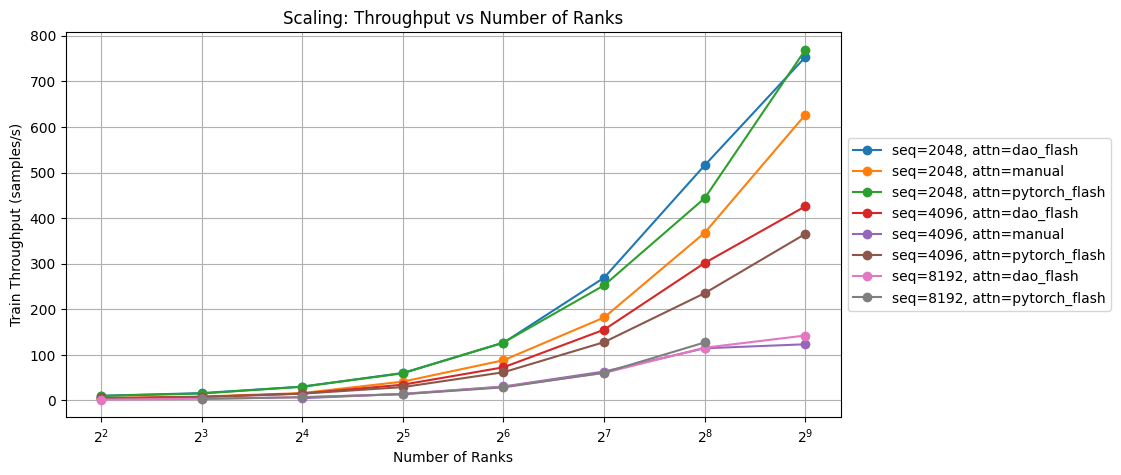

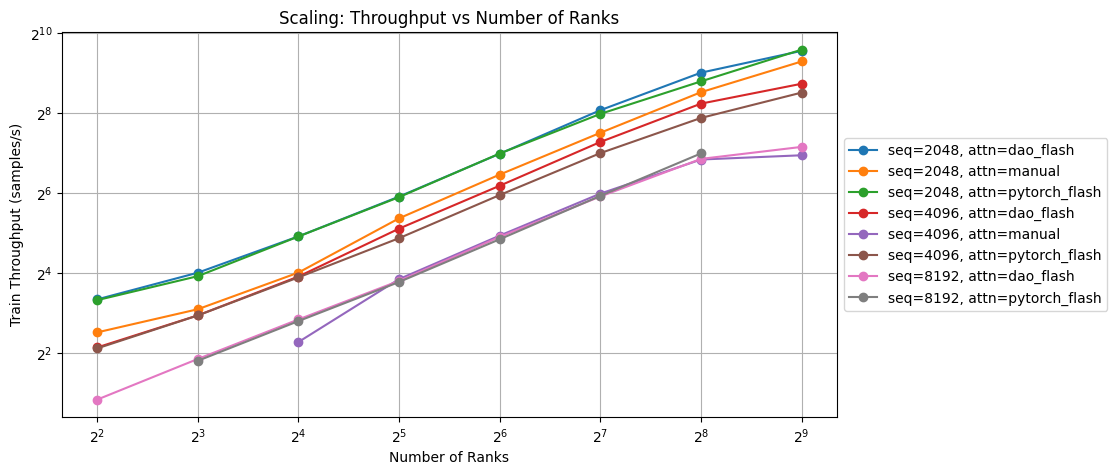

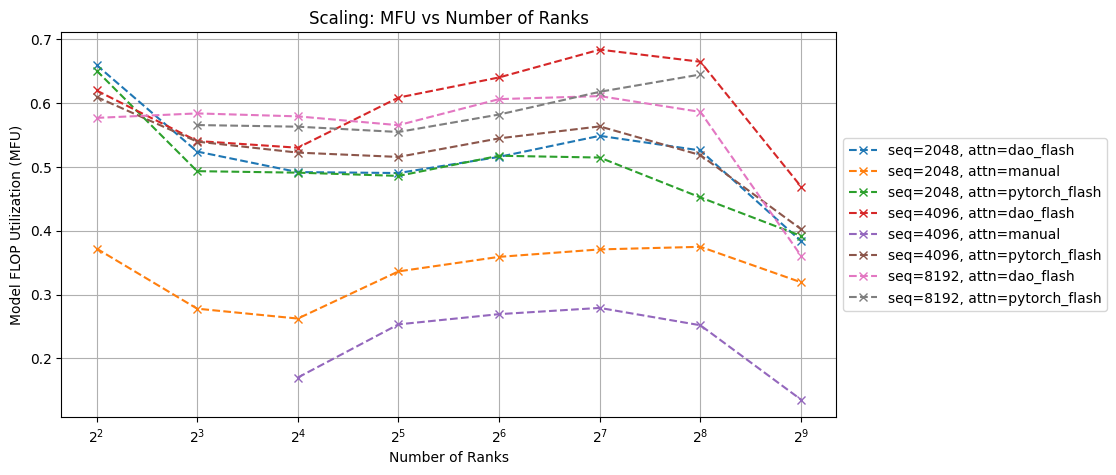

In [47]:
# --- Plot 1: Throughput ---
fig1, ax1 = plt.subplots(figsize=(10, 5))

for (seq_len, attn_impl), group in best_rows.groupby(["sequence_length", "attention_implementation"]):
    group = group.sort_values("num_ranks")
    label = f"seq={seq_len}, attn={attn_impl}"
    ax1.plot(group["num_ranks"], group["train samples/s"], marker='o', label=label)

ax1.set_title("Scaling: Throughput vs Number of Ranks")
ax1.set_xlabel("Number of Ranks")
ax1.set_ylabel("Train Throughput (samples/s)")
ax1.set_xscale("log", base=2)  # ← logarithmic x-axis
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.grid(True, which="both")

# --- Plot 1: Throughput ---
fig1, ax1 = plt.subplots(figsize=(10, 5))

for (seq_len, attn_impl), group in best_rows.groupby(["sequence_length", "attention_implementation"]):
    group = group.sort_values("num_ranks")
    label = f"seq={seq_len}, attn={attn_impl}"
    ax1.plot(group["num_ranks"], group["train samples/s"], marker='o', label=label)

ax1.set_title("Scaling: Throughput vs Number of Ranks")
ax1.set_xlabel("Number of Ranks")
ax1.set_ylabel("Train Throughput (samples/s)")
ax1.set_xscale("log", base=2)  # ← logarithmic x-axis
ax1.set_yscale("log", base=2)  # ← logarithmic x-axis
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.grid(True, which="both")

# --- Plot 2: MFU ---
fig2, ax2 = plt.subplots(figsize=(10, 5))

for (seq_len, attn_impl), group in best_rows.groupby(["sequence_length", "attention_implementation"]):
    group = group.sort_values("num_ranks")
    label = f"seq={seq_len}, attn={attn_impl}"
    ax2.plot(group["num_ranks"], group["train mfu (16-bit)"], marker='x', linestyle='--', label=label)

ax2.set_title("Scaling: MFU vs Number of Ranks")
ax2.set_xlabel("Number of Ranks")
ax2.set_ylabel("Model FLOP Utilization (MFU)")
ax2.set_xscale("log", base=2)  # ← logarithmic x-axis
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.grid(True, which="both")

plt.show()

## Memory footprint analysis

As the memory pressure increases, the throughput can plummet. To investigate this, we can plot the peak memory usage per rank against the throughput and highlight the best configurations.

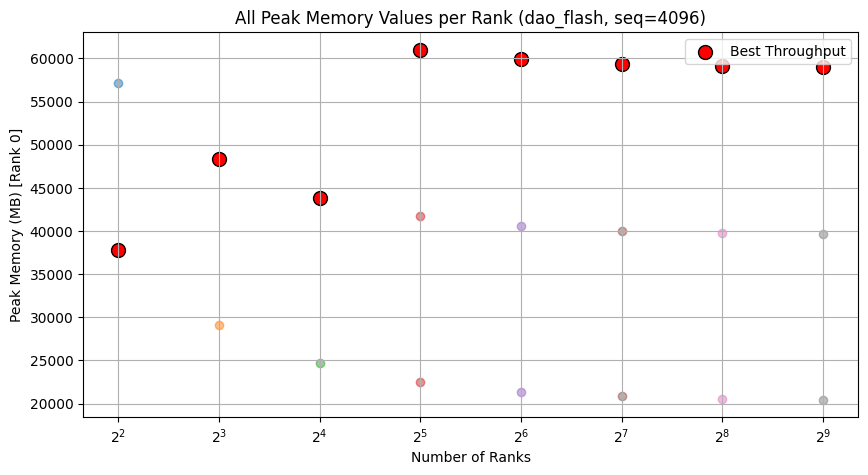

In [ ]:
sequence_length = 4096
attention_implementation = "dao_flash"


import matplotlib.pyplot as plt

# Filter down to single attention impl and sequence length
df_valid = df_filtered[
    df_filtered["train samples/s"].notnull() &
    (df_filtered["sequence_length"] == sequence_length) &
    (df_filtered["attention_implementation"] == attention_implementation)
]

# Best row per num_ranks
best_rows = (
    df_valid
    .sort_values("train samples/s", ascending=False)
    .drop_duplicates(subset=["num_ranks"])
)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot all memory values as background points
for num_ranks, group in df_valid.groupby("num_ranks"):
    ax.scatter(
        [num_ranks] * len(group),
        group["peak memory rank 0 (MB)"],
        alpha=0.5,
        label=f"{num_ranks} ranks" if num_ranks not in best_rows["num_ranks"].values else None
    )

# Plot best ones as red dots with black edge
ax.scatter(
    best_rows["num_ranks"],
    best_rows["peak memory rank 0 (MB)"],
    color="red",
    edgecolors="black",
    s=100,
    label="Best Throughput"
)

# Final touches
ax.set_title(f"All Peak Memory Values per Rank ({attention_implementation}, seq={sequence_length})")
ax.set_xlabel("Number of Ranks")
ax.set_ylabel("Peak Memory (MB) [Rank 0]")
ax.set_xscale("log", base=2)
ax.grid(True, which="both")
ax.legend()
plt.show()